In [39]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import ollama
import re
import networkx as nx
import matplotlib.pyplot as plt
import time
import requests

In [61]:
url = "https://en.wikipedia.org/wiki/Trivago"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Example: Extracting headings and links
headings = [h.get_text(strip=True) for h in soup.find_all(['h1', 'h2', 'h3'])]
links = [a['href'] for a in soup.find_all('a', href=True)]


In [62]:
def extract_text_from_url(url):
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument('--no-sandbox')
    options.add_argument('--window-size=1920,1080')
    options.add_argument("user-agent=Mozilla/5.0")

    from selenium.webdriver.chrome.service import Service

    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)


    driver.get(url)
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    driver.quit()

    text_blocks = []

    if soup.title:
        text_blocks.append(f"Title: {soup.title.string.strip()}")
    for tag in soup.find_all(['h1', 'h2', 'h3', 'p']):
        content = tag.get_text(strip=True)
        if content and len(content.split()) > 3:
            text_blocks.append(content)

    return '\n'.join(text_blocks[:20])

In [63]:
structured_text= extract_text_from_url(url)
response = ollama.chat(
    model='llama3.2',
    messages=[
        {"role": "system", "content": "You are a knowledge graph generator. Output triples in the format (subject, predicate, object)."},
        {"role": "user", "content": structured_text}
    ]
)

triples_text = response['message']['content']
print(triples_text)




Here are some triples extracted from the text:

1. (Rolf Schrömgens, CEO, Trivago N.V.)
2. (Trivago N.V., company, specializes in travel and lodging)
3. (Stephan Stubner, Managing Director, resigned in 2007)
4. (Düsseldorf, Germany, founded location of Trivago N.V. in 2005)
5. (Samwer brothers, investors, €1 million funding in 2005)
6. (Florian Heinemann, investor, €1 million funding in 2005)
7. (Christian Vollmann, investor, €1 million funding in 2005)
8. (HOWZAT media LLP, investor, $1.14 million Series B funding in 2007)
9. (Insight Venture Partners, investor, $52.86 million acquisition of Trivago N.V. shares in 2010)
10. (Expedia, American travel company, stake in Trivago acquired in 2012 for $632 million)
11. (Rheinfabrik, mobile app product and development company, acquired by Trivago in 2014)
12. (Base7booking, Cloud-PMS company, portion acquired by Trivago in 2016)
13. (Axel Hefer, CEO, replacement of Rolf Schrömgens in 2020)
14. (COVID-19 pandemic, caused sales to fall by 95% 

In [64]:
import re

# Parse string output into structured triples
triples = re.findall(r'\d+\.\s*(.*?),\s*(.*?),\s*(.*?)\s*(?:\n|$)', triples_text)

# Clean up whitespace
triples = [(s.strip(), p.strip(), o.strip()) for s, p, o in triples]


In [65]:
triples

[('(Rolf Schrömgens', 'CEO', 'Trivago N.V.)'),
 ('(Trivago N.V.', 'company', 'specializes in travel and lodging)'),
 ('(Stephan Stubner', 'Managing Director', 'resigned in 2007)'),
 ('(Düsseldorf', 'Germany', 'founded location of Trivago N.V. in 2005)'),
 ('(Samwer brothers', 'investors', '€1 million funding in 2005)'),
 ('(Florian Heinemann', 'investor', '€1 million funding in 2005)'),
 ('(Christian Vollmann', 'investor', '€1 million funding in 2005)'),
 ('(HOWZAT media LLP', 'investor', '$1.14 million Series B funding in 2007)'),
 ('(Insight Venture Partners',
  'investor',
  '$52.86 million acquisition of Trivago N.V. shares in 2010)'),
 ('(Expedia',
  'American travel company',
  'stake in Trivago acquired in 2012 for $632 million)'),
 ('(Rheinfabrik',
  'mobile app product and development company',
  'acquired by Trivago in 2014)'),
 ('(Base7booking',
  'Cloud-PMS company',
  'portion acquired by Trivago in 2016)'),
 ('(Axel Hefer', 'CEO', 'replacement of Rolf Schrömgens in 2020)'

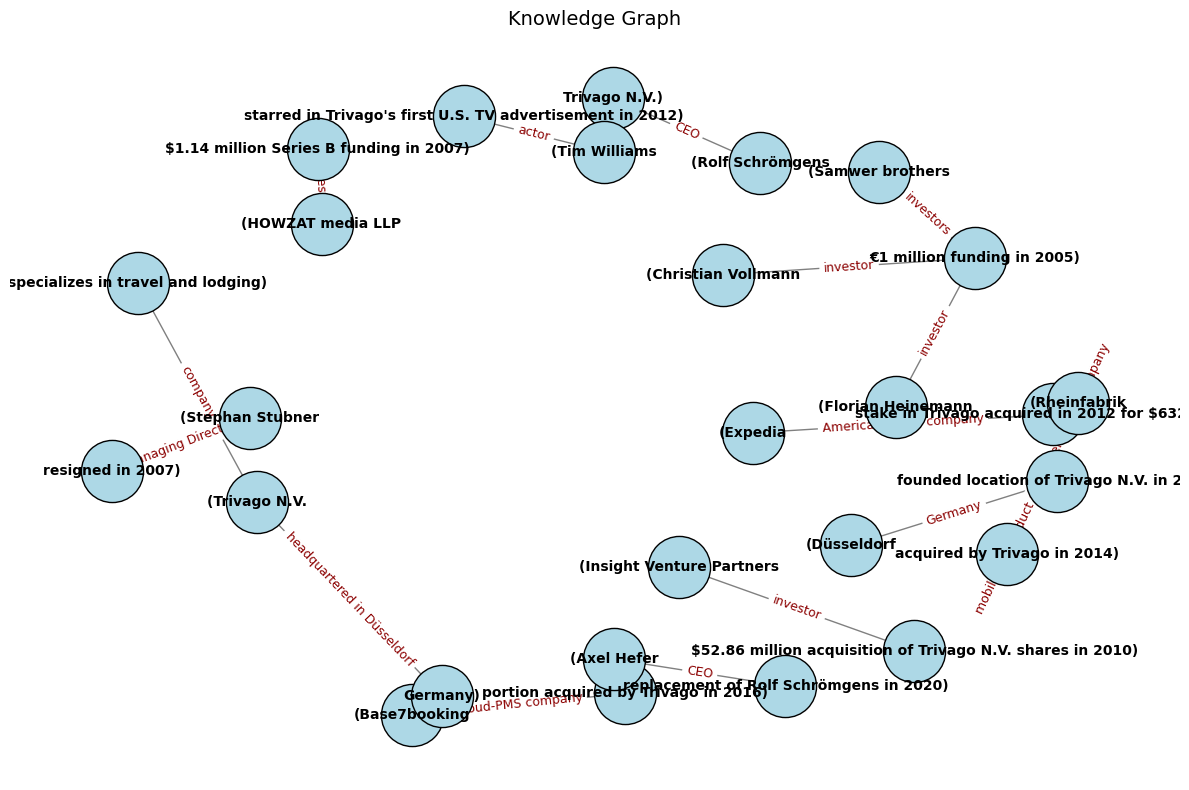

In [66]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
G = nx.DiGraph()

# Add parsed triples
for subject, predicate, object_ in triples:
    G.add_edge(subject, object_, label=predicate)

# Visualize
pos = nx.spring_layout(G, k=0.6, iterations=50)

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=2000, edgecolors='black')
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkred', font_size=9)

plt.title("Knowledge Graph", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()
